# **Lab 9.1 Generative Adversarial Network**
**NOTE :** Use the dataset from lab5.

In [14]:
import torch
from torch import nn
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [15]:
!nvidia-smi

## Architecture
Complete the GAN architecture that generates RGB images of size 128x128.

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, im_ch=3, hidden_dim=256):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 4),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(hidden_dim // 4, hidden_dim // 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 8),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(hidden_dim // 8, hidden_dim // 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 16),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(hidden_dim // 16, im_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(noise.size(0), noise.size(1), 1, 1)
        return self.gen(noise)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, im_ch=3, hidden_dim=32):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(im_ch, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.disc(image).view(-1)

Complete the function below. The `get_noise` function generates a random noise tensor that is typically used as input to a Generator
- `n_sample`: The number of noise samples to generate.

- `z_dim`: The dimensionality of each noise vector.

- `device`: The device on which the tensor will be allocated. By default, it is set to 'cuda'

In [20]:
### START CODE HERE ###
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)
### END CODE HERE ###

In [21]:
n_sample = 25
z_dim = 100
noise = get_noise(n_sample, z_dim)
assert noise.shape == (n_sample, z_dim), f"Expected shape {(n_sample, z_dim)}, but got {noise.shape}"

noise_cpu = get_noise(n_sample, z_dim, device='cpu')
assert noise_cpu.device.type == 'cpu', f"Expected tensor to be on 'cpu', but got {noise_cpu.device.type}"
assert noise.dtype == torch.float32, f"Expected dtype to be torch.float32, but got {noise.dtype}"

## Preparation
Prepare all training components such as the dataset, batch size, optimizer, and model, etc. No need to perform a train-test split.

In [22]:
### START CODE HERE ###
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
])

img_path = "/home/pthongm/data"

generator = Generator().to(device)
discriminator = Discriminator().to(device)

datasets = datasets.ImageFolder(root = img_path, transform=transforms)
dataloader = DataLoader(datasets, batch_size=16, shuffle=True, num_workers=2)

lr = 0.001
beta1 = 0.5
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
### END CODE HERE ###

Display first batch of dataset.

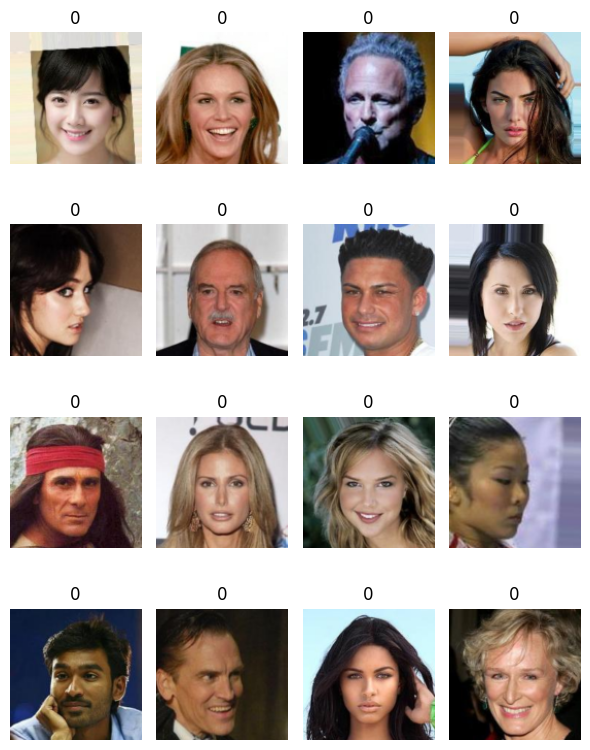

In [23]:
### START CODE HERE ###
images , labels = next(iter(dataloader))

fig,axs = plt.subplots(4,4, figsize = (6,8))

for i , (img,label) in enumerate(zip(images[:16], labels[:16])):
    img_np = img.permute(1, 2, 0).numpy()
    row = i // 4
    col = i % 4
    axs[row,col].imshow(img_np, cmap = "grey")
    axs[row,col].set_title(f"{label}")
    axs[row,col].axis('off')

plt.tight_layout()
plt.show()
### END CODE HERE ###

Use `get_noise` to generate noise with 25 samples, and then use the generator to generate images with that noise.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/1.png?raw=true)


</details>

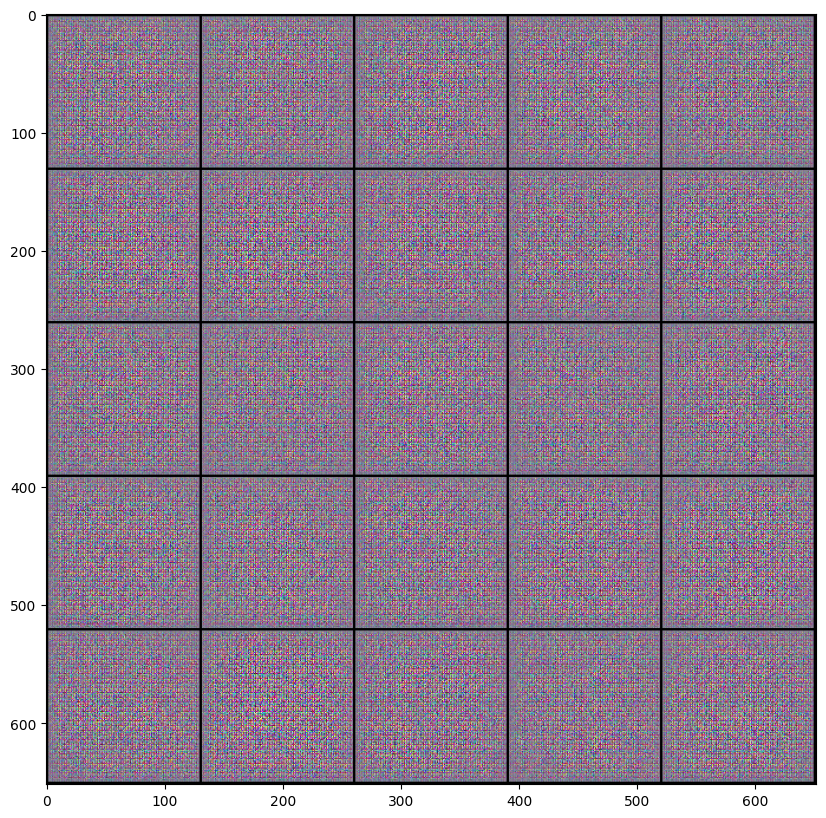

In [25]:
### START CODE HERE ###

with torch.no_grad():
    fake_images = generator(noise).cuda()

def show_images(images, nrow=5):
    images = images.cpu()
    images = (images + 1) / 2
    grid_img = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    plt.show()

show_images(fake_images)

### END CODE HERE ###

Complete the training function that trains and logs the average loss for both the generator and discriminator, and generates sample images at each epoch (using the same input vector as the previous part) to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).
<details>
<summary>
<font size="3" color="orange">
<b>Expected output in tensorboard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/2.png?raw=true)


</details>


In [11]:
### START CODE HERE ###
def train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=10, writer=None, checkpoint_path=None, device='cuda'):
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    for epoch in range(epochs):
        gen_loss_avg = 0
        disc_loss_avg = 0
        num_batches = len(dataloader)
        train_bar = tqdm(dataloader, desc=f" Training Epoch [{epoch+1}/{epochs}]", unit='batch')

        for real_images, _ in train_bar:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            disc_opt.zero_grad()

            noise = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(noise)

            real_pred = discriminator(real_images)
            fake_pred = discriminator(fake_images.detach())
            real_loss = criterion(real_pred, torch.ones_like(real_pred))
            fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
            disc_loss = (real_loss + fake_loss) / 2

            disc_loss.backward()
            disc_opt.step()

            gen_opt.zero_grad()

            fake_pred = discriminator(fake_images)
            gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))

            gen_loss.backward()
            gen_opt.step()

            gen_loss_avg += gen_loss.item() / num_batches
            disc_loss_avg += disc_loss.item() / num_batches

        if writer:
            writer.add_scalar('Generator Loss', gen_loss_avg, epoch)
            writer.add_scalar('Discriminator Loss', disc_loss_avg, epoch)

        with torch.no_grad():
            generator.eval()
            fake_images_test = generator(test_noise.to(device))
            fake_images_test = (fake_images_test + 1) / 2

            img_grid = torchvision.utils.make_grid(fake_images_test, nrow=5)
            if writer:
                writer.add_image('Generated Images', img_grid, epoch)

            generator.train()

        if checkpoint_path:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_opt_state_dict': gen_opt.state_dict(),
                'disc_opt_state_dict': disc_opt.state_dict(),
                'epoch': epoch
            }, f"{checkpoint_path}/gan_checkpoint_epoch_{epoch}.pth")

        print(f"Epoch {epoch + 1}/{epochs} | Generator Loss: {gen_loss_avg:.4f} | Discriminator Loss: {disc_loss_avg:.4f}")
### END CODE HERE ###


In [ ]:
### START CODE HERE ###
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = Generator(z_dim=100).to(device)
discriminator = Discriminator(im_ch=3).to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

dataloader = DataLoader(datasets, batch_size=16, shuffle=True)

test_noise = torch.randn(25, 100).to(device)

writer = SummaryWriter(log_dir='runs/gan_experiment')

train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim=100, epochs=10, writer=writer, checkpoint_path='/home/pthongm/gan_checkpoints', device=device)

writer.close()
### END CODE HERE ###

 Training Epoch [1/10]:   0%|                                                               | 0/1875 [00:00<?, ?batch/s]

 Training Epoch [1/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.76batch/s]


Epoch 1/10 | Generator Loss: 4.1392 | Discriminator Loss: 0.2032


 Training Epoch [2/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.78batch/s]


Epoch 2/10 | Generator Loss: 3.5609 | Discriminator Loss: 0.2409


 Training Epoch [3/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.46batch/s]


Epoch 3/10 | Generator Loss: 3.7239 | Discriminator Loss: 0.2030


 Training Epoch [4/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:14<00:00, 25.02batch/s]


Epoch 4/10 | Generator Loss: 4.0466 | Discriminator Loss: 0.1697


 Training Epoch [5/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.57batch/s]


Epoch 5/10 | Generator Loss: 4.4285 | Discriminator Loss: 0.1462


 Training Epoch [6/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:19<00:00, 23.67batch/s]


Epoch 6/10 | Generator Loss: 4.5562 | Discriminator Loss: 0.1417


 Training Epoch [7/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.78batch/s]


Epoch 7/10 | Generator Loss: 4.7044 | Discriminator Loss: 0.1349


 Training Epoch [8/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.81batch/s]


Epoch 8/10 | Generator Loss: 5.0642 | Discriminator Loss: 0.1097


 Training Epoch [9/10]: 100%|████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.14batch/s]


Epoch 9/10 | Generator Loss: 5.2712 | Discriminator Loss: 0.1105


 Training Epoch [10/10]: 100%|███████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.39batch/s]


Epoch 10/10 | Generator Loss: 5.3918 | Discriminator Loss: 0.0970


Test Genereate the image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/3.png?raw=true)


</details>

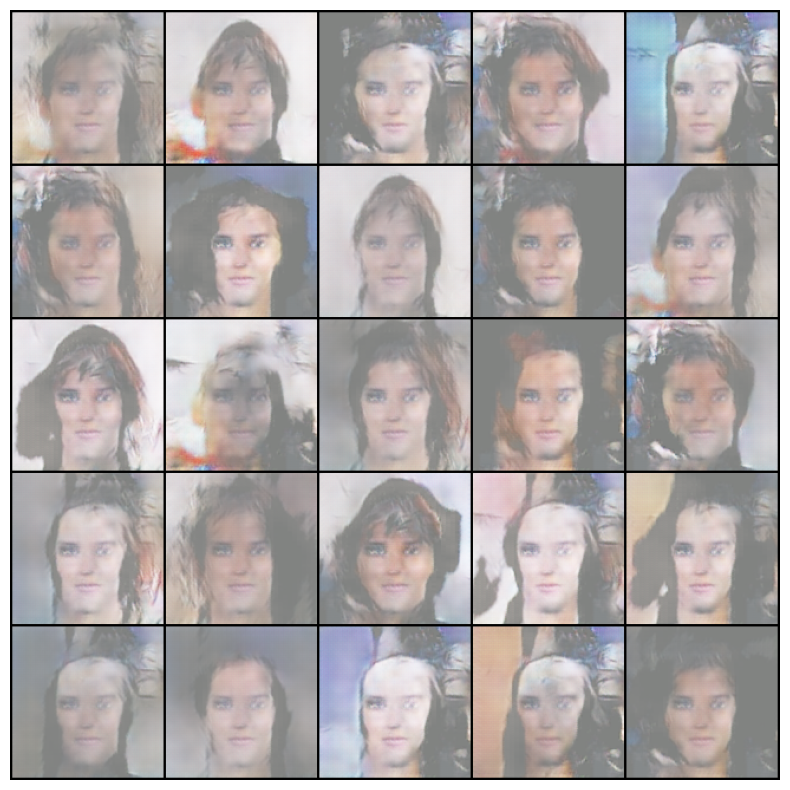

In [ ]:
### START CODE HERE ###

def generate_and_display_grid(generator, z_dim, grid_size=(5, 5), device='cuda'):
    generator.eval()

    noise = torch.randn(grid_size[0] * grid_size[1], z_dim, device=device)

    with torch.no_grad():
        fake_images = generator(noise).cpu()

    fake_images = (fake_images + 1) / 2

    img_grid = torchvision.utils.make_grid(fake_images, nrow=grid_size[1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

generate_and_display_grid(generator, z_dim=100)
### END CODE HERE ###

---

# Question
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?